# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [2]:
#pip install pyLDAvis==3.4.1 

In [5]:
#pip install spacy

In [38]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models


import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

In [39]:
# add any additional libaries you need here
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/justinfarnan_hakkoda/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [5]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [8]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [9]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [10]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

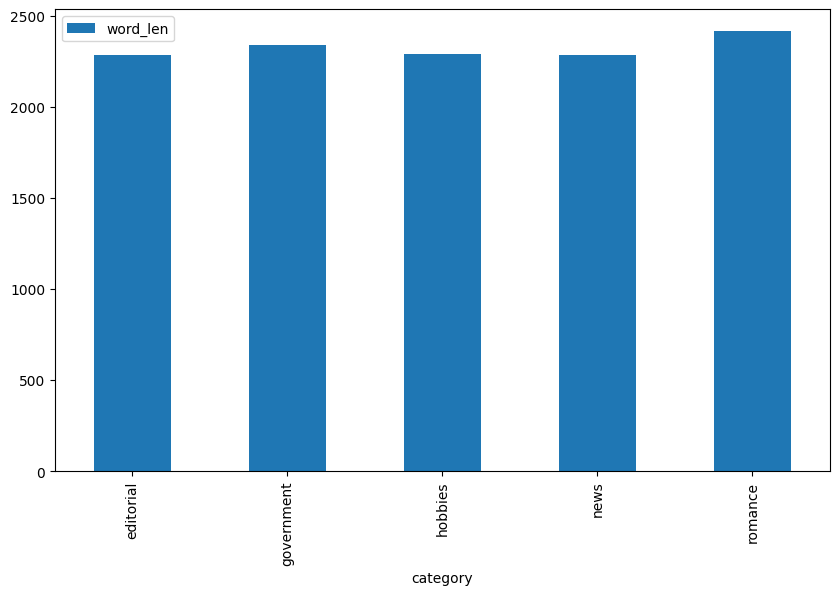

In [11]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [12]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/opt/anaconda3/envs/text_mining/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [13]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

In [59]:
tfidf_array = tfidf_text_vectors.toarray()
tfidf_names = tfidf_text_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_array, columns=tfidf_names)
tfidf_df.head()


,00,000,10,100,11,12,120,13,14,15,...,yes,yesterday,yield,york,young,younger,youngsters,youth,zone,zoning
0,0.0,0.046852,0.0,0.000000,0.000000,0.000000,0.0,0.023450,0.0,0.019456,...,0.0,0.0,0.000000,0.016895,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.040107,0.0,0.000000,0.000000,0.015896,0.0,0.020074,0.0,0.000000,...,0.0,0.0,0.000000,0.043389,0.000000,0.0,0.0,0.0,0.062348,0.0
2,0.0,0.000000,0.0,0.041794,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.034956,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.016735,0.0,0.000000,0.000000,0.039797,0.0,0.000000,0.0,0.020849,...,0.0,0.0,0.036429,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.014687,0.0,0.018843,0.019635,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0


In [60]:
cv_array = count_text_vectors.toarray()
cv_names = count_text_vectorizer.get_feature_names_out()
cv_df = pd.DataFrame(cv_array, columns=cv_names)
cv_df.head()

,00,000,10,100,11,12,120,13,14,15,...,yes,yesterday,yield,york,young,younger,youngsters,youth,zone,zoning
0,0,3,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,3,0,0,0,1,0,1,0,0,...,0,0,0,3,0,0,0,0,2,0
2,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
3,0,1,0,0,0,2,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The tfidf_text_vectors contains the text data represented by the TF-IDF (Term Frequency-Inverse Document Frequency) scores, with each row corresponding to a document. These TF-IDF values highlight the importance of words within a specific document relative to the entire collection of documents. The Count Vectorizer is used to determine how many times a term is used across the entire collection of articles. It's worth noting that if stop words are not removed, they would appear with high values, indicating their frequent usage but not necessarily their importance.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [14]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [15]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [16]:
# Your code here
# Get the topic distribution for each document
document_topics = nmf_text_model.transform(tfidf_text_vectors)

# Assign each document to the most prominent topic
df['topic'] = document_topics.argmax(axis=1)

# Tally the categories for each topic
topic_category_tally = df.groupby(['topic', 'category']).size().unstack(fill_value=0)
print(topic_category_tally)

category  editorial  government  hobbies  news  romance
topic                                                  
0                20           4        0     8        0
1                 4           0        8     0       29
2                 2          26       26    11        0
3                 0           0        1    17        0
4                 1           0        1     8        0


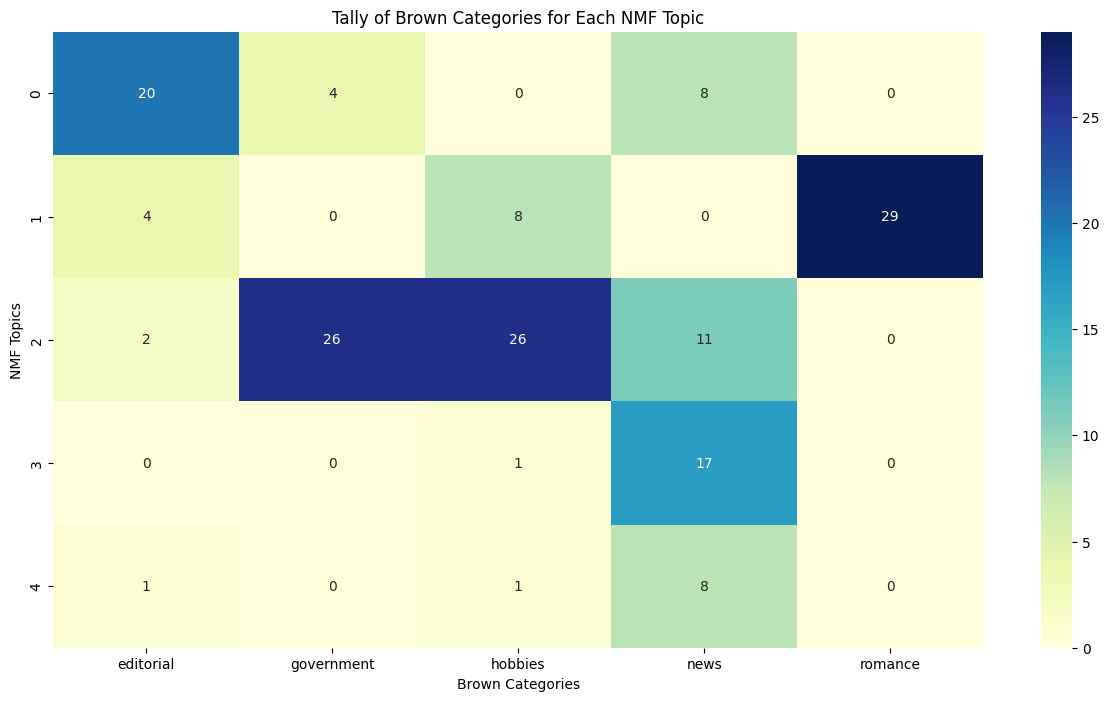

In [23]:
# Plotting the tally for visual interpretation
plt.figure(figsize=(15, 8))
sns.heatmap(topic_category_tally, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Tally of Brown Categories for Each NMF Topic')
plt.xlabel('Brown Categories')
plt.ylabel('NMF Topics')
plt.show()

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The comparison of the five-topic NMF model to the original Brown categories reveals several interesting alignments and thematic focuses. Topic 0 predominantly aligns with editorial articles, having 20 tallies, which indicates a strong connection to this category. It also includes 8 news articles, suggesting that this topic encompasses general reporting and commentary. Topic 1 is closely related to romantic articles, with 29 tallies indicating a clear thematic focus on personal stories and narratives. This topic also includes some news articles, but its primary association is with romance.

Topic 2 presents a broader thematic range, capturing an equal number of government and hobbies articles, each with 26 tallies. Additionally, it includes 11 news articles, which is a notable number. This diversity suggests that Topic 2 encompasses multiple themes and may require deeper analysis to fully understand its scope. Topic 3 predominantly aligns with news articles, having 17 tallies, indicating a strong focus on current events and reporting. There is minimal representation from other categories, with only 1 hobby article included.

Lastly, Topic 4 is similar to Topic 3 in that it primarily falls under the news category, with 8 tallies. There are a few articles from other categories, such as editorial and hobbies, but the majority align with news. This suggests that Topic 4, like Topic 3, has a strong focus on news-related content.

Overall, the NMF model shows varying degrees of alignment with the original Brown categories, with some topics demonstrating clear thematic focuses and others presenting a broader range of themes.


## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [24]:
# Your code here
from sklearn.decomposition import TruncatedSVD

# Fit the LSA model
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
W_text_matrix_lsa = lsa_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix_lsa = lsa_text_model.components_

In [44]:
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


In [ ]:
# call display_topics on your model

Q: What is your interpretation of the display topics output? 

A: Based on the above topics, Topic 0 seems to align with news or editorial categories, given the formal address and narrative content suggested by words like "said," "mr," "mrs," "state," and "man." Topic 1 appears less descriptive, with conversational words like "said," "ll," "didn," "thought," and "got," which could fit into the romance category or potentially any narrative-driven text. Topic 2, with words such as "mrs," "mr," "said," "kennedy," and "khrushchev," is focused on significant historical figures and formal titles, suggesting it could fall under news or government. Topics 3 and 4 both seem to align with hobbies, as they mention "club," "game," "jr," "university," "game," "league," "baseball," "ball," and "team," indicating a focus on social activities, educational institutions, and sports, particularly baseball.

In [27]:
# Get the topic distribution for each document using LSA
document_topics_lsa = lsa_text_model.transform(tfidf_text_vectors)

# Assign each document to the most prominent LSA topic
df['lsa_topic'] = document_topics_lsa.argmax(axis=1)

topic_category_tally_lsa = df.groupby(['lsa_topic', 'category']).size().unstack(fill_value=0)
print(topic_category_tally_lsa)

category   editorial  government  hobbies  news  romance
lsa_topic                                               
0                 27          30       36    34       21
1                  0           0        0     0        8
3                  0           0        0     3        0
4                  0           0        0     7        0


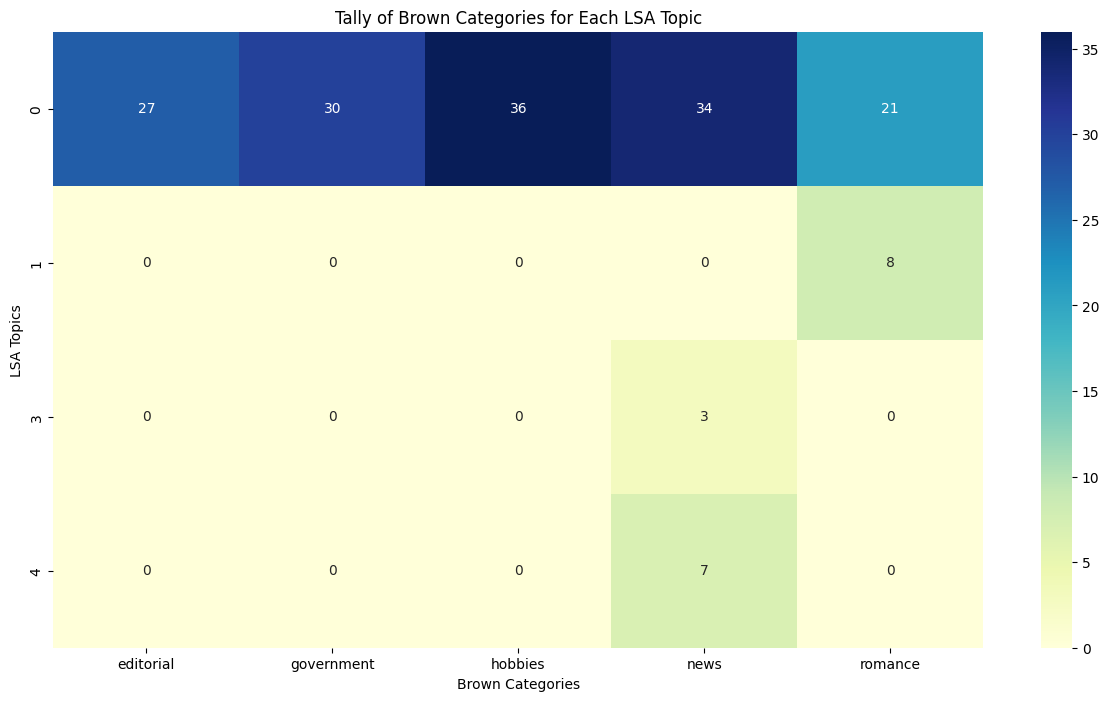

In [28]:
plt.figure(figsize=(15, 8))
sns.heatmap(topic_category_tally_lsa, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Tally of Brown Categories for Each LSA Topic')
plt.xlabel('Brown Categories')
plt.ylabel('LSA Topics')
plt.show()

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The comparison of the five-topic LSA (Latent Semantic Analysis) model to the original Brown categories reveals the following alignments and thematic focuses:

Topic 0 predominantly aligns with multiple categories, capturing a significant number of articles from the editorial (27 articles), government (30 articles), hobbies (36 articles), news (34 articles), and romance (21 articles) categories. This broad coverage suggests that Topic 0 is a general or mixed theme, encompassing diverse content types across various genres.

Topic 1 exclusively aligns with the news category, with 8 articles falling under this topic. This indicates that Topic 1 has a specific focus on news-related content, similar to what was observed in some of the NMF topics.

Topic 2 does not show any significant alignment with any category, implying that it might represent a very specific or niche theme not prominently featured in the selected Brown categories.

Topic 3 is another specific topic, aligning exclusively with the news category with 3 articles. Like Topic 1, it highlights news content but with a smaller representation, suggesting a possibly more specialized focus within news.

Topic 4 primarily aligns with the news category, containing 7 articles. This indicates that, similar to Topics 1 and 3, Topic 4 has a focus on news content but captures different aspects or subsets of news articles.

In summary, the LSA model shows a dominant general topic (Topic 0) covering multiple categories and three specific topics (Topics 1, 3, and 4) focusing on news content. Topic 2 appears to be an outlier with no significant alignment, potentially representing a niche theme. The comparison suggests that while LSA can capture broad thematic content across genres, it also identifies specific themes within the news category.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [49]:
# Fit your LDA model here
lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_para_model.components_


In [50]:
# Call `display_topics` on your fitted model here
display_topics(lda_para_model, tfidf_text_vectorizer.get_feature_names_out())



Topic 00
  clay (0.54)
  game (0.47)
  place (0.45)
  cut (0.45)
  home (0.44)

Topic 01
  pool (0.77)
  use (0.71)
  national (0.70)
  area (0.57)
  good (0.56)

Topic 02
  million (0.60)
  military (0.57)
  sales (0.54)
  aircraft (0.54)
  equipment (0.50)

Topic 03
  feed (3.04)
  said (1.47)
  head (1.08)
  meeting (0.94)
  daily (0.91)

Topic 04
  said (1.83)
  sam (0.67)
  eyes (0.63)
  thought (0.63)
  little (0.58)

Topic 05
  mrs (1.05)
  said (0.88)
  old (0.67)
  mr (0.56)
  man (0.56)

Topic 06
  said (2.73)
  board (0.85)
  000 (0.66)
  court (0.56)
  county (0.55)

Topic 07
  state (1.08)
  medical (0.75)
  shelter (0.68)
  program (0.53)
  service (0.53)

Topic 08
  state (0.85)
  united (0.78)
  states (0.72)
  government (0.70)
  president (0.67)

Topic 09
  fiscal (1.00)
  property (0.86)
  island (0.69)
  tax (0.69)
  state (0.61)


In [51]:
# Get the topic distribution for each document using LSA
document_topics_lda = lda_para_model.transform(tfidf_text_vectors)

# Assign each document to the most prominent LSA topic
df['lda_topic'] = document_topics_lda.argmax(axis=1)

topic_category_tally_lda = df.groupby(['lda_topic', 'category']).size().unstack(fill_value=0)
print(topic_category_tally_lda)

category   editorial  government  hobbies  news  romance
lda_topic                                               
0                  0           0       11     7        0
1                  2           3        4     1        0
2                  5           3        2     2        0
3                  0           0        1     1        2
4                  0           2        0     0        5
5                  5           1        7    11       21
6                  0           1        1     9        0
7                  0           5        5     1        0
8                 15          11        1    12        1
9                  0           4        4     0        0


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The LDA model has produced topics with significant overlap and many repeated terms, indicating challenges in generating distinct and meaningful topics. Some topics, like those related to sports, are clearer, but many contain generic or repeated terms, making it hard to identify specific themes. This analysis suggests a need for further tuning of the model parameters or preprocessing steps to improve the distinctiveness and interpretability of the topics.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Topic 00 seems to focus on recreational activities and locations, possibly related to home and outdoor games. The presence of words like "game," "place," and "home" suggests a theme around leisure activities and home settings. This topic might be best categorized under hobbies. Topic 01 appears to relate to outdoor or community activities, with "pool," "area," and "national" indicating a focus on public spaces and their usage. The word "good" adds a positive connotation to these activities. This topic could fall under the editorial section. Topic 02 is clearly related to economics and military, with terms like "million," "military," "sales," "aircraft," and "equipment" suggesting discussions around military spending, economic transactions, and defense equipment. This topic fits well under government. Topic 03 seems to focus on governmental and economic issues, as indicated by terms like "tax," "state," and "property." The presence of "said" suggests that reported speech or quotations are prevalent, possibly from news articles. This topic aligns with news.

In summary, the LDA model has generated the following topics: Topic 00 focuses on recreational and home activities, indicated by words like "game," "place," and "home," and could be categorized under hobbies. Topic 01 relates to outdoor or community activities, with words such as "pool," "national," and "area," and could fall under the editorial section. Topic 02 centers on economic and military themes, highlighted by terms like "million," "military," and "sales," and fits well under government. Topic 03 covers governmental and economic issues, as suggested by words like "tax," "state," and "property," and aligns with news. While there is still some overlap, the topics are more distinct compared to previous outputs, providing clearer thematic insights into the content of the articles. Further refinement of the model parameters or preprocessing steps might still be necessary to improve the separation and distinctiveness of the topics.

In [52]:
lda_display = pyLDAvis.lda_model.prepare(lda_para_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [53]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The PC scatterplot above is a good representation to show how similar or different each topic is. If the topics are close together, they are similar, and if they are not, they are different. The size of the circles indicates how relevant that specific topic is compared to others. When we look at our chart, we can see that topics 9 and 6 are farther away from each other, indicating that the topics are different, but their sizes are the largest out of all 10. This tells me that these two topics show up the most in the articles we analyzed and that they are vastly different.

The salient terms graph highlights the most important or distinctive words within a particular topic. For example, the terms "state," "united," "states," and "government" are the top four words for topic nine, indicating that this would possibly fall under the government category if we were to classify it. Topic 6 has vastly different words that, personally, I would say might fall under editorial or romance.
